# Producing multiple peaked synthetic profiles
## Background
It is standard practice in flood modelling to use design rainfall profiles generated by FEH/ReFH2. We are interested in examining whether distributing rainfall over time in multiple peaks, rather than just one, will result in a different flooding outcome. 

## Constructing synthetic multiple peaked events
The FEH single-peak profiles are always produced with a single peak which can be characterised by:
1) The total corresponding rainfall volume $V$.  
2) The duration $d$ (start to end).  
3) The shape of the peak, defined here: https://refhdocs.hydrosolutions.co.uk/Design-DDF-Rainfall-Hyetographs/Design-Storm-Profiles/  
 
To construct multiple peaked events, we need to consider:  
 1) The rainfall volume$ V_1,...V_N$ for each peak. Suggestion: use $V/N$, so we have the same total rainfall.  
 2) The shape of each peak. Suggestion: use the same shape, but different peak rainfall height so it gives the desired volume  given a start-to-end duration for the peak.  
 3) The start-to-end duration of each peak. This is a parameter we can play with, but probably we will mainly look at short durations.  
 4) The spacing between peaks. Here, the question is what a "fair" spacing for comparison so that the overall "event duration" is the same, and this is probably a bit subjective. We could also consider this as another parameter to play with.  
 


In [2]:
from datetime import datetime, timedelta
import pandas as pd
from dateutil.relativedelta import relativedelta
import sys
import matplotlib.patches as mpatches
from matplotlib import dates as mdates
import re
sys.path.insert(1, '../')
from Functions import *

### Define the different methods 

In [6]:
percent_increases =['0', '05','10','20','30']
method = 'single-peak'
duration = '6h'
N_subpeaks = 1
default_peak_shape='refh2-summer'
total_mm_accum=59.29
total_duration_minutes = (int(duration[0]) * 60) +1
subpeak_duration_minutes=total_duration_minutes/6
peak_before_frac = 0.5

In [7]:
# Create datetimes to go with values
start = datetime(2022,8,1,0,0,0)
end = start + relativedelta(hours=int(duration[0]))
end = end - timedelta(minutes=1) 

if total_duration_minutes == (int(duration[0]) * 60) +1:
    seconds = (end - start).total_seconds() + 61
else:    
    seconds = (end - start).total_seconds() + 60 
step = timedelta(minutes=1)
datetimes = []
for i in range(0, int(seconds), int(step.total_seconds())):
    datetimes.append(start + timedelta(seconds=i))       

### Create a single peaked profile with 10% extra volume

In [10]:
for percent_increase in percent_increases:

    # Find the multiplier and use to multiply the total event accumulation
    multiplier = np.float64('1.{}'.format(percent_increase))
    total_mm_accum=  59.29 * multiplier

    # Find accumulation and rate
    accum, rate = calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes,peak_before_frac)
    # Create as dataframe
    accum_df = pd.DataFrame({'Dates': datetimes,  'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
    # Keep only columns needed for feeding to ReFH2
    accum_df = accum_df[['Dates','Rate (mm/min)']]

    # Write to csv
    accum_df.to_csv("{}r_100yrRP/PreLossRemoval/{}_sp_+{}%volume.csv".format(duration,duration, percent_increase),
                   header = False, index = False)
    if percent_increase == '0':
        all_accums = accum_df.copy()
        all_accums.rename(columns ={'Rate (mm/min)':percent_increase}, inplace = True)
    else:
        all_accums[percent_increase] = accum_df['Rate (mm/min)']
    
    print("Percent increase in volume:" + percent_increase+ '%' + '. New total volume: ' + str(total_mm_accum))
    print("Maximum rate (mm/min): " + str(round(all_accums[percent_increase].max(),3)))

Percent increase in volume:0%. New total volume: 59.29
Maximum rate (mm/min): 1.237
Percent increase in volume:05%. New total volume: 62.2545
Maximum rate (mm/min): 1.299
Percent increase in volume:10%. New total volume: 65.21900000000001
Maximum rate (mm/min): 1.361
Percent increase in volume:20%. New total volume: 71.148
Maximum rate (mm/min): 1.485
Percent increase in volume:30%. New total volume: 77.077
Maximum rate (mm/min): 1.608


In [9]:
for col_num, percent_increase in enumerate(percent_increases):
    post_loss_removal = pd.read_csv("6hr_100yrRP/PostLossRemoval/6h_sp_+{}_urban.csv".format(percent_increase))
    print("Maximum rate (mm/min): " + str(round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max(),5)))
    print("Maximum rate (mm/min): " + str(round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].sum(),3)))

Maximum rate (mm/min): 0.30137
Maximum rate (mm/min): 14.44
Maximum rate (mm/min): 0.32102
Maximum rate (mm/min): 15.381
Maximum rate (mm/min): 0.34111
Maximum rate (mm/min): 16.344
Maximum rate (mm/min): 0.38259
Maximum rate (mm/min): 18.332
Maximum rate (mm/min): 0.42582
Maximum rate (mm/min): 20.403


### Check what the percentage variation is in the other metrics

In [32]:
# previous = 14.7
# for current in [15.615, 16.594, 18.616]:
#     print(((float(current)-previous)/previous)*100)
    
# previous = 1.096
# for current in [1.15,1.205,1.315]:
#     print(((float(current)-previous)/previous)*100)

# previous = 0.269
# for current in [0.287, 0.305, 0.342]:
#     print(((float(current)-previous)/previous)*100)

## Pre and post loss removal: plot single peak profiles with scaled volumes

In [33]:
colors =['#8aadd4', '#6882c2', '#4556af', '#232b9d', '#00008b']

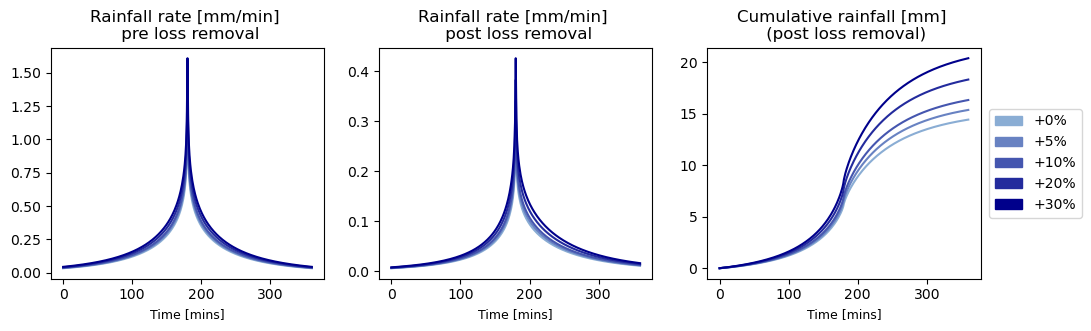

In [35]:
fig,axs=plt.subplots(1,3, figsize=(12,3))
for col_num, percent_increase in enumerate(percent_increases):
    # Read in post loss removal rainfall rate
    pre_loss_removal = pd.read_csv("6hr_100yrRP/PreLossRemoval/6h_sp_+{}%volume.csv".format(percent_increase), names =['Time', 'Rain'])
    post_loss_removal = pd.read_csv("6hr_100yrRP/PostLossRemoval/6h_sp_+{}_urban.csv".format(percent_increase))
    # Find cumulative rainfall rate
    post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()

    # PLot
    axs[0].plot(range(total_duration_minutes), pre_loss_removal['Rain'], color = colors[col_num])
    axs[0].set_xlabel('Time [mins]', fontsize = 9)
    axs[0].set_title('Rainfall rate [mm/min] \n pre loss removal')
    
    axs[1].plot(np.array(range(total_duration_minutes)) , post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'],
               colors[col_num])
    axs[1].set_xlabel('Time [mins]', fontsize = 9)
    axs[1].set_title('Rainfall rate [mm/min] \n post loss removal')
    
    axs[2].plot(np.array(range(total_duration_minutes)) , post_loss_removal['cumulative_rainfall_this_min'],
               colors[col_num])
    axs[2].set_xlabel('Time [mins]', fontsize = 9)
    axs[2].set_title('Cumulative rainfall [mm] \n (post loss removal)')
    
texts = ['+0%','+5%','+10%', '+20%' , '+30%'] 
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.2, 0.5), loc='center', ncol=1, prop={'size': 10} )
fig.savefig("6hr_100yrRP/PostLossRemoval/Profile_plots.PNG");        